# Extract Bottleneck Features for Train Set

In [1]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os

# load the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = np.squeeze(y_train)
print('data loaded')

# load inceptionV3 model + remove final classification layers
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))
print('model loaded')

# obtain bottleneck features (train)
if os.path.exists('inception_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('inception_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    print('calculating now ...')
    # pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(x_train[i], (139, 139, 3)) 
                            for i in range(0, len(x_train))]).astype('float32')
    inception_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    # extract, process, and save bottleneck features
    features = model.predict(inception_input_train)
    features = np.squeeze(features)
    np.savez('inception_features_train', features=features)
print('bottleneck features saved (train)')

Using TensorFlow backend.


data loaded
model loaded
bottleneck features detected (train)
bottleneck features saved (train)


# Plot t-SNE Embedding of Bottleneck Features for Train Set

tsne features detected (test)
tsne features obtained


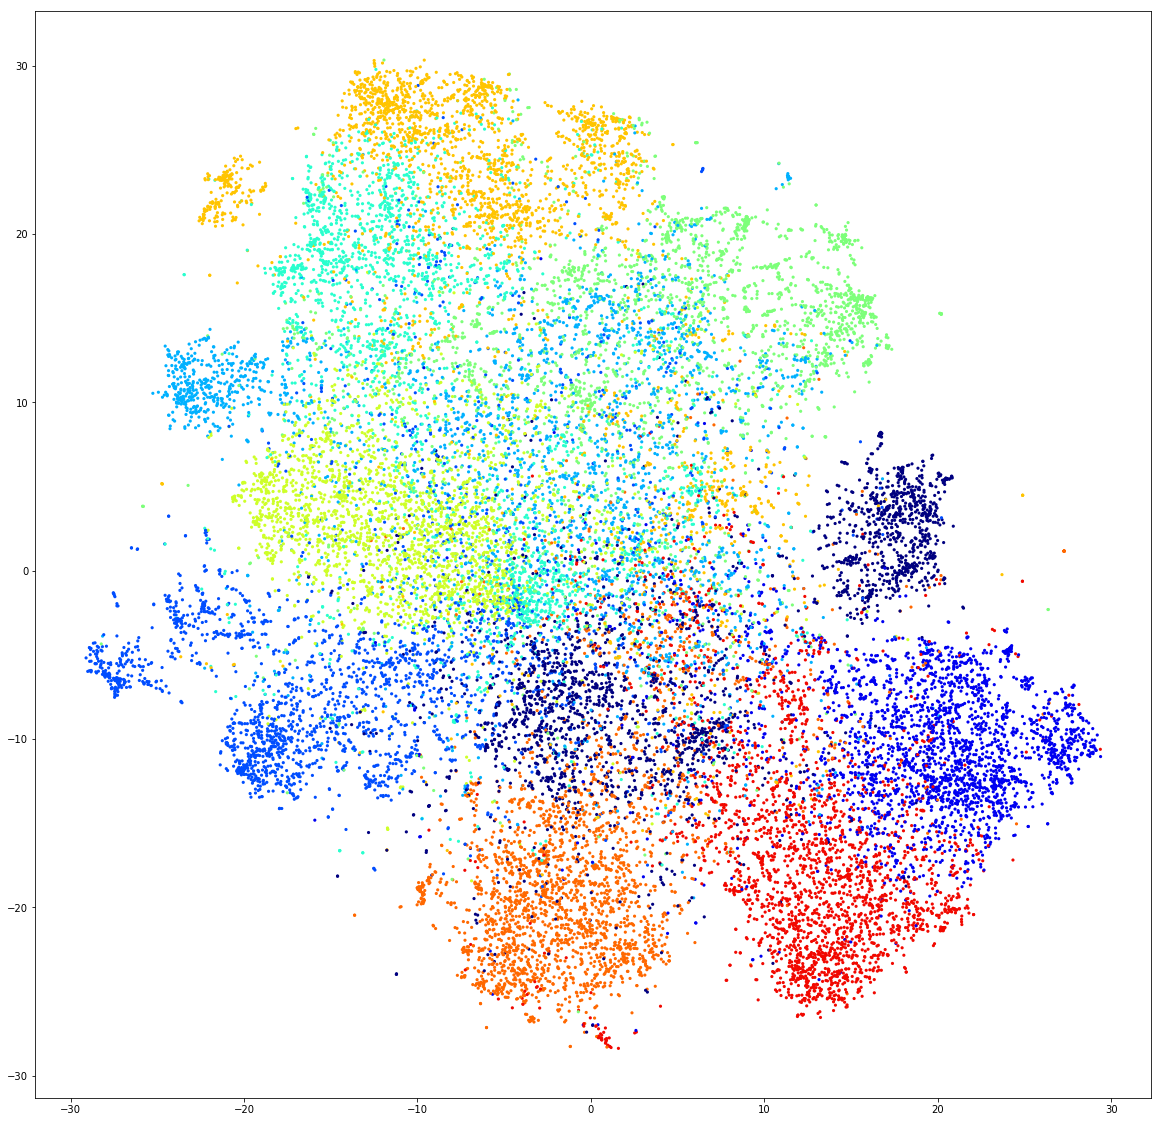

In [2]:
from tsne import bh_sne
import matplotlib.pyplot as plt
%matplotlib inline

# reshape bottleneck features + reduce dimensionality with t-SNE
if os.path.exists('tsne_features.npz'):
    print('tsne features detected (test)')
    tsne_features = np.load('tsne_features.npz')['tsne_features']
else:
    print('tsne features not detected (test)')
    print('calculating now ...')
    tsne_features = bh_sne(features.reshape([features.shape[0], np.prod(features.shape[1:])]).astype('float64')[:25000])
    np.savez('tsne_features', tsne_features=tsne_features)
print('tsne features obtained')

# plot the features
plt.figure(figsize=(20,20))
plt.scatter(tsne_features[:,0], tsne_features[:,1], c=plt.cm.jet(y_train/10), s=10, edgecolors='none')
plt.show()

# Extract Bottleneck Features for Test Set

In [3]:
# obtain bottleneck features (test)
if os.path.exists('inception_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('inception_features_test.npz')['features_test']
else:
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(x_test[i], (139, 139, 3)) 
                       for i in range(0, len(x_test))]).astype('float32')
    inception_input_test = preprocess_input(big_x_test)
    # extract, process, and save bottleneck features (test)
    features_test = model.predict(inception_input_test)
    features_test = np.squeeze(features_test)
    np.savez('inception_features_test', features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features detected (test)
bottleneck features saved (test)


# Train a Shallow NN

In [4]:
from keras.utils import np_utils

# one-hot encode the labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [9]:
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=100, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.best.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(features, y_train, batch_size=50, epochs=50,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_99 (Conv2D)           (None, 2, 2, 100)         819300    
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 100)         0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 820,310.0
Trainable params: 820,310.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 3.29630, saving model to m

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.best.hdf5')

# evaluate test accuracy
score = model.evaluate(features_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 82.6800%
